In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
matches = pd.read_csv("matches.csv")
teams = pd.read_csv("teams.csv")

In [4]:
matches["utc_date"] = pd.to_datetime(matches["utc_date"])

In [5]:
team_names = teams.set_index("team_id")["name"].to_dict()
matches["home_team_name"] = matches["home_team_id"].map(team_names)
matches["away_team_name"] = matches["away_team_id"].map(team_names)

In [ ]:

home = matches[["home_team_id", "winner"]].copy()
home["team_id"] = home["home_team_id"]
home["is_home"] = True

away = matches[["away_team_id", "winner"]].copy()
away["team_id"] = away["away_team_id"]
away["is_home"] = False


all_teams = pd.concat([home, away], ignore_index=True)

all_teams["win"] = ((all_teams["is_home"]) & (all_teams["winner"] == "HOME_TEAM")) | \
                   ((~all_teams["is_home"]) & (all_teams["winner"] == "AWAY_TEAM"))

all_teams["draw"] = all_teams["winner"] == "DRAW"

team_stats = all_teams.groupby("team_id").agg(
    games_played=("winner", "count"),
    wins=("win", "sum"),
    draws=("draw", "sum")
)

team_stats["win_rate"] = team_stats["wins"] / team_stats["games_played"]
team_stats["draw_rate"] = team_stats["draws"] / team_stats["games_played"]
team_stats["losses"] = team_stats["games_played"] - team_stats["wins"] - team_stats["draws"]
team_stats["loss_rate"] = team_stats["losses"] / team_stats["games_played"]

team_stats["team_name"] = team_stats.index.map(team_names)


In [10]:
print("Shapiro-Wilk Test for Win Rate:")
print(stats.shapiro(team_stats["win_rate"]))

Shapiro-Wilk Test for Win Rate:
ShapiroResult(statistic=np.float64(0.9594440904033895), pvalue=np.float64(0.0046665739204501885))


In [11]:
la_liga_ids = teams[teams["league_id"] == 3]["team_id"]
bundesliga_ids = teams[teams["league_id"] == 4]["team_id"]

print("\nLevene Test (Win Rate La Liga vs Bundesliga):")
print(stats.levene(
    team_stats.loc[team_stats.index.isin(la_liga_ids), "win_rate"],
    team_stats.loc[team_stats.index.isin(bundesliga_ids), "win_rate"]
))



Levene Test (Win Rate La Liga vs Bundesliga):
LeveneResult(statistic=np.float64(0.00018751312174737725), pvalue=np.float64(0.9891500834565559))


In [12]:
print("\nT-test (Win Rate La Liga vs Bundesliga):")
print(stats.ttest_ind(
    team_stats.loc[team_stats.index.isin(la_liga_ids), "win_rate"],
    team_stats.loc[team_stats.index.isin(bundesliga_ids), "win_rate"],
    equal_var=False
))


T-test (Win Rate La Liga vs Bundesliga):
TtestResult(statistic=np.float64(-0.130289320313402), pvalue=np.float64(0.8970782562366924), df=np.float64(35.24847030639993))


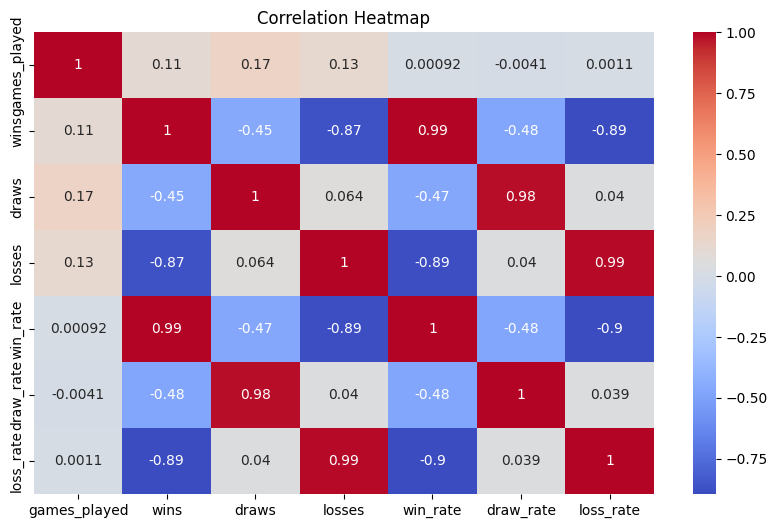

In [13]:
numeric_cols = ["games_played", "wins", "draws", "losses", "win_rate", "draw_rate", "loss_rate"]
plt.figure(figsize=(10, 6))
sns.heatmap(team_stats[numeric_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

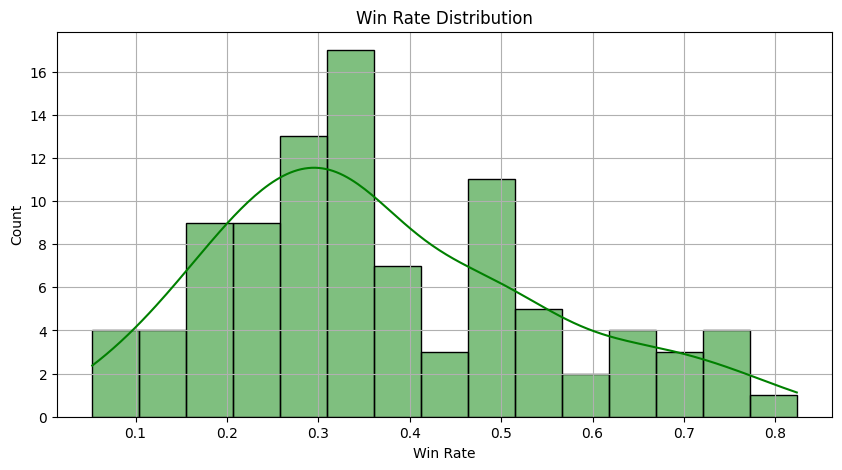

In [14]:
plt.figure(figsize=(10, 5))
sns.histplot(team_stats["win_rate"], kde=True, bins=15, color='green')
plt.title("Win Rate Distribution")
plt.xlabel("Win Rate")
plt.ylabel("Count")
plt.grid(True)
plt.show()

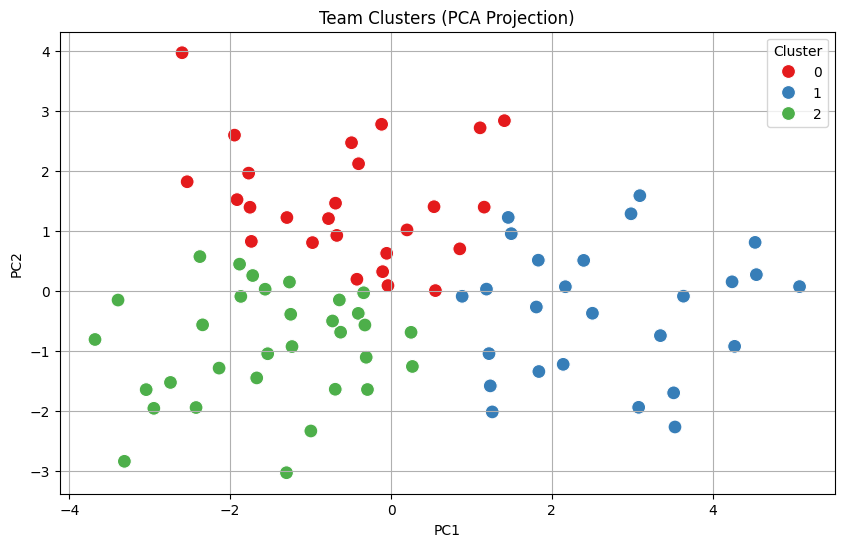

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(team_stats[numeric_cols])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_pca)

team_stats["cluster"] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clusters, palette="Set1", s=100)
plt.title("Team Clusters (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()